In [128]:
import numpy as np
import json
import re
from urllib.request import urlopen
from pyserini import search
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

np.random.seed(1)

[nltk_data] Downloading package wordnet to /home/robbie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/robbie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/robbie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Read in text data for training

In [150]:
qfile = 'https://github.com/castorini/anserini-tools/blob/63ceeab1dd94c1221f29b931d868e8fab67cc25c/topics-and-qrels/qrels.robust04.txt?raw=true'
docids = set()
for line in urlopen(qfile):
  qid, round, docid, score = line.strip().split()
  new_docid = docid.decode('UTF-8')
  docids.add(new_docid)

docids = list(docids)
np.random.shuffle(docids)
len(docids), docids[0]

(174787, 'LA101590-0068')

In [160]:
data = []
searcher = search.SimpleSearcher.from_prebuilt_index('robust04')
for docid in docids[:50]:
  try:
    text = searcher.doc(docid).raw()
    data.append(text)
  except:
    continue

cleaned_data = []
for text in data:
  new_text = text.replace('<P>', ' ')
  new_text = new_text.replace('</P>', ' ')
  new_text = new_text.replace('<DATE>', ' ')
  new_text = new_text.replace('</DATE>', ' ')
  new_text = new_text.replace('<HEADLINE>', ' ')
  new_text = new_text.replace('</HEADLINE>', ' ')
  new_text = new_text.replace('<TEXT>', ' ')
  new_text = new_text.replace('</TEXT>', ' ')
  new_text = new_text.replace('\n', ' ')
  new_text = new_text.replace("\'", '')
  new_text = new_text.replace('--', ' ')
  cleaned_data.append(new_text)
  
cleaned_data[0]

Attempting to initialize pre-built index robust04.
/home/robbie/.cache/pyserini/indexes/index-robust04-20191213.15f3d001489c97849a010b0a4734d018 already exists, skipping download.
Initializing robust04...


'    October 15, 1990, Monday, Home Edition         SYRIA MAKES CLEAR WHOS DOMINANT POWER IN BEIRUT;     NEWS ANALYSIS         In the rubbled forecourt of Lebanons presidential palace at Baabda, Syrian troops Sunday heated coffee over a fire fueled with shredded posters of fallen Christian strongman Michel Aoun.     The flag of Damascus flew over the Lebanese Defense Ministry in nearby Yarze, and for the first time in 12 years, Syrian soldiers patrolled the streets of East Beirut, capital of the Christian heartland.     If Syrian President Hafez Assad still harbors the ambition to restore Greater Syria, including Lebanon   and many Damascus-based diplomats are convinced that he does   Saturdays lightning assault that toppled Aoun was a decisive step. At the least it erased any doubt that Assad would remain the ringmaster in Lebanon, the sorrowful sideshow of power politics in the Middle East.     Assads government waited for months before delivering the final blow to Aoun, who had repe

## Clean data

In [190]:
stemmer = nltk.stem.PorterStemmer()
stop_words = set(nltk.corpus.stopwords.words('english'))

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    tokens = pattern.findall(text)
    stemmed_tokens = []
    for token in tokens:
      stemmed_token = stemmer.stem(token.replace("'", ''))
      if stemmed_token not in stop_words:
        stemmed_tokens.append(stemmed_token)
    return stemmed_tokens

tokens_by_doc = [tokenize(doc) for doc in cleaned_data[:25]]

In [191]:
tokens_by_doc[0]

['octob',
 'monday',
 'home',
 'edit',
 'syria',
 'make',
 'clear',
 'domin',
 'power',
 'beirut',
 'new',
 'analysi',
 'rubbl',
 'forecourt',
 'lebanon',
 'presidenti',
 'palac',
 'baabda',
 'syrian',
 'troop',
 'sunday',
 'heat',
 'coffe',
 'fire',
 'fuel',
 'shred',
 'poster',
 'fallen',
 'christian',
 'strongman',
 'michel',
 'aoun',
 'flag',
 'damascu',
 'flew',
 'lebanes',
 'defens',
 'ministri',
 'nearbi',
 'yarz',
 'first',
 'time',
 'year',
 'syrian',
 'soldier',
 'patrol',
 'street',
 'east',
 'beirut',
 'capit',
 'christian',
 'heartland',
 'syrian',
 'presid',
 'hafez',
 'assad',
 'still',
 'harbor',
 'ambit',
 'restor',
 'greater',
 'syria',
 'includ',
 'lebanon',
 'mani',
 'damascu',
 'base',
 'diplomat',
 'convinc',
 'doe',
 'saturday',
 'lightn',
 'assault',
 'toppl',
 'aoun',
 'wa',
 'decis',
 'step',
 'least',
 'eras',
 'ani',
 'doubt',
 'assad',
 'would',
 'remain',
 'ringmast',
 'lebanon',
 'sorrow',
 'sideshow',
 'power',
 'polit',
 'middl',
 'east',
 'assad',
 'go

In [192]:
# want to treat the tokens as one long list, rather than a list of tokens per document
# to do this, will insert a special character in between each document to stop the training there
# TLDR insert a stop token between each document to avoid using next/prev document as context
SPECIAL_STOP_TOKEN = '*!!!*'

def combine_tokens():
  ret = []
  for token_list in tokens_by_doc:
    ret.extend(token_list)
    ret.append(SPECIAL_STOP_TOKEN)

  return ret

tokens_with_stops = combine_tokens()

print(len(tokens_with_stops))
# should equal number of documents being used
len([token for token in tokens_with_stops if token == SPECIAL_STOP_TOKEN])

8606


25

## Create vocabulary maps

In [193]:
token_to_id = {}
id_to_token = {}

def make_vocabulary(tokens):
  for token in tokens:
    if token not in token_to_id:
      id_no = len(token_to_id) + 1
      token_to_id[token] = id_no
      id_to_token[id_no] = token

for doc in tokens_by_doc:
  make_vocabulary(doc)

print(len(token_to_id))

2518


## Create dataset

In [194]:
def create_one_hot(token_id):
  vector = np.zeros(len(token_to_id) + 1)
  vector[token_id] = 1
  return vector

def yield_range(*ranges):
  for iterable in ranges:
    yield from iterable

def create_dataset(window_size=2):
  X = []
  y = []
  
  # note that this includes stop tokens, which will need to be skipped
  token_count = len(tokens_with_stops)
  print(token_count)

  for i in range(token_count):
    if tokens_with_stops[i] == SPECIAL_STOP_TOKEN:
      continue

    indexes = yield_range(range(max(0, i - window_size), i), range(i, min(token_count, i + window_size + 1)))
    for j in indexes:
      if j == i:
        continue
      
      if tokens_with_stops[j] == SPECIAL_STOP_TOKEN:
        break

      X.append(create_one_hot(token_to_id[tokens_with_stops[i]]))
      y.append(create_one_hot(token_to_id[tokens_with_stops[j]]))

  return np.asarray(X), np.asarray(y)

X, y = create_dataset()

8606


In [195]:
X.shape, y.shape

((34078, 2519), (34078, 2519))

## Create and Initialize Network

In [196]:
def init_network(vocab_size: int, n_embeddings: int) -> dict:
  model = {
    'w1': np.random.randn(vocab_size + 1, n_embeddings),
    'w2': np.random.randn(n_embeddings, vocab_size + 1),
  }
  return model

### Train Model

In [197]:
def softmax(outputs):
  res = []
  for x in outputs:
    res.append(np.exp(x - np.max(x)) / np.exp(x - np.max(x)).sum())
  return res

def safe_log(array):
  for i in range(len(array)):
    for x in range(len(array[i])):
      if array[i][x] > 0:
        array[i][x] = np.log(array[i][x])
  return array

def cross_entropy_loss(z, y):
  return - np.sum(y * safe_log(z))

def forward_prop(model, X):
  cache = {}
  cache['a1'] = X @ model['w1']
  cache['a2'] = cache['a1'] @ model['w2']
  cache['z'] = softmax(cache['a2'])
  return cache

def back_prop(model, X, y, alpha):
  cache = forward_prop(model, X)
  da2 = cache['z'] - y
  dw2 = cache['a1'].T @ da2
  da1 = da2 @ model['w2'].T
  dw1 = X.T @ da1
  model['w1'] -= alpha * dw1
  model['w2'] -= alpha * dw2
  return cross_entropy_loss(cache['z'], y)

100%|██████████| 50/50 [1:21:28<00:00, 97.76s/it]


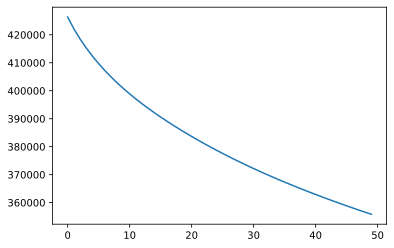

In [204]:
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# hyperparams
n_iter = 50
learning_rate = 0.0005
embedding_size = 10

model = init_network(len(token_to_id), embedding_size)
model['w1'].shape, model['w2'].shape

losses = []

for i in tqdm(range(n_iter)):
  losses.append(back_prop(model, X, y, learning_rate))

plt.plot(range(len(losses)), losses)
plt.show()

### Evaluate Embeddings

In [205]:
def get_embedding(model, word, stem=True):
  try:
    if stem:
      token = stemmer.stem(word.replace("'", ''))
    else:
      token = word
    idx = token_to_id[token]
  except KeyError:
    print(f'{token} not in corpus')
  one_hot = create_one_hot(idx)
  return forward_prop(model, one_hot)['a1']

def magnitude(vector):
  return np.sqrt(np.sum(vector ** 2))

def cosim(vector1, vector2):
  dot = np.dot(vector1, vector2)
  mag_x = magnitude(vector1)
  mag_y = magnitude(vector2)
  return dot / (mag_x * mag_y)

def similar(model, word, num_common, reverseList=False):
  similarities = []
  word_embedding = get_embedding(model, word)
  for token in token_to_id.keys():
    if token == stemmer.stem(word):
      continue
    token_embedding = get_embedding(model, token, stem=False)
    similarities.append((cosim(token_embedding, word_embedding), token))
  similarities.sort(reverse=not reverseList)
  return similarities[:num_common]

In [210]:
# most similar vectors
similar(model, 'new', 10)

[(0.9421840377293443, 'chronicl'),
 (0.8643683597731969, 'hella'),
 (0.8115978807647962, 'intellig'),
 (0.8076289776759172, 'japanes'),
 (0.8057691121469024, 'edg'),
 (0.8032276108794905, 'women'),
 (0.7941946128422769, 'norway'),
 (0.7830390243385259, 'overshadow'),
 (0.7688248879336826, 'debat'),
 (0.7580325178938492, 'nowher')]

In [209]:
# least similar vectors
similar(model, 'fire', 10, reverseList=True)

[(-0.9295996298060148, 'take'),
 (-0.8685883201832698, 'also'),
 (-0.8248836243049644, 'sefton'),
 (-0.8159970485977733, 'ave'),
 (-0.8058551716387781, 'path'),
 (-0.8058491433138886, 'word'),
 (-0.7987552219578151, 'southern'),
 (-0.7924815619213991, 'amount'),
 (-0.7853011956456262, 'met'),
 (-0.7776969724600471, 'vega')]

In [213]:
import json

def save_model(model, output_name='embeddings.txt'):
  embedding_dict = {}
  for token in token_to_id.keys():
    embedding_dict[token] = list(get_embedding(model, token, stem=False))
  
  with open(output_name, 'w') as outfile:
    json.dump(embedding_dict, outfile, indent=4)

save_model(model)

In [201]:
token_to_id

{'octob': 1,
 'monday': 2,
 'home': 3,
 'edit': 4,
 'syria': 5,
 'make': 6,
 'clear': 7,
 'domin': 8,
 'power': 9,
 'beirut': 10,
 'new': 11,
 'analysi': 12,
 'rubbl': 13,
 'forecourt': 14,
 'lebanon': 15,
 'presidenti': 16,
 'palac': 17,
 'baabda': 18,
 'syrian': 19,
 'troop': 20,
 'sunday': 21,
 'heat': 22,
 'coffe': 23,
 'fire': 24,
 'fuel': 25,
 'shred': 26,
 'poster': 27,
 'fallen': 28,
 'christian': 29,
 'strongman': 30,
 'michel': 31,
 'aoun': 32,
 'flag': 33,
 'damascu': 34,
 'flew': 35,
 'lebanes': 36,
 'defens': 37,
 'ministri': 38,
 'nearbi': 39,
 'yarz': 40,
 'first': 41,
 'time': 42,
 'year': 43,
 'soldier': 44,
 'patrol': 45,
 'street': 46,
 'east': 47,
 'capit': 48,
 'heartland': 49,
 'presid': 50,
 'hafez': 51,
 'assad': 52,
 'still': 53,
 'harbor': 54,
 'ambit': 55,
 'restor': 56,
 'greater': 57,
 'includ': 58,
 'mani': 59,
 'base': 60,
 'diplomat': 61,
 'convinc': 62,
 'doe': 63,
 'saturday': 64,
 'lightn': 65,
 'assault': 66,
 'toppl': 67,
 'wa': 68,
 'decis': 69,
 '